# Ứng dụng BERT: Từ Lý thuyết đến Thực hành

Notebook này trình bày một pipeline hoàn chỉnh để ứng dụng mô hình BERT, . Mục tiêu là không chỉ áp dụng mô hình mà còn đánh giá một cách khoa học.

**Nội dung quan trọng:**
1.  **Chạy thử trên model BERT "from-scratch":** Sử dụng mô hình BERT được xây dựng thủ công cho 2 task  Masked Language Model (MLM) và Next Sentence Prediction (NSP)
2.  **So sánh với Baseline:** Thêm mô hình TF-IDF + Logistic Regression làm cơ sở so sánh hiệu năng.
3.  **Huấn luyện trên tập dữ liệu lớn hơn:** Sử dụng một phần đáng kể (5000 mẫu) của tập dữ liệu IMDb để kết quả đáng tin cậy hơn.
4.  **Đánh giá sâu hơn:** Bổ sung ma trận nhầm lẫn (confusion matrix) và phân tích lỗi (error analysis) để hiểu rõ điểm mạnh, điểm yếu của mô hình.
5.  **Trực quan hóa Embedding:** Dùng t-SNE để trực quan hóa không gian embedding của BERT và so sánh với TF-IDF.

**Cấu trúc Notebook:**
- **Phần 1**: Tải và chạy thử BERT "from-scratch" (`bert.py`).
- **Phần 2**: Fine-tune BERT cho bài toán phân loại cảm xúc trên tập IMDb.
  - 2.1: Cấu hình và tải dữ liệu.
  - 2.2: Xây dựng và đánh giá mô hình Baseline (TF-IDF).
  - 2.3: Fine-tune mô hình BERT pre-trained.
  - 2.4: Đánh giá chi tiết mô hình BERT (Metrics, Confusion Matrix, Error Analysis).
- **Phần 3**: Khám phá và trực quan hóa biểu diễn của BERT.
- **Phần 4**: Trực quan hóa trọng số Attention.

---

## Cài đặt và Tải thư viện

In [1]:
%pip install transformers[torch] datasets scikit-learn seaborn matplotlib bertviz --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertModel, DataCollatorWithPadding
from bertviz import model_view, head_view
import warnings

warnings.filterwarnings('ignore')
print(f"PyTorch version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 2.6.0+cu124
Using device: cuda


## Phần 1: Tải và Chạy thử BERT "from-scratch"

Để chứng minh sự cài đặt về kiến trúc BERT là đúng, tải file `bert.py` chứa mã nguồn cài đặt lại mô hình từ đầu. Sau đó, chạy một ví dụ nhỏ để kiểm tra các tác vụ Pre-training (Masked Language Model và Next Sentence Prediction).

In [4]:
# Tải file bert.py
try:
    # from google.colab import files
    # # uploaded = files.upload() # Bỏ comment dòng này để tải file lên
    # # import sau khi tải lên
    import bert as bert_scratch
    print("Tải và import file 'bert.py' thành công.")
except ImportError:
    print("Lỗi: Không tìm thấy file 'bert.py'. Vui lòng tải file lên Colab session.")
    bert_scratch = None

Tải và import file 'bert.py' thành công.


In [9]:
# Chạy các kiểm thử với 2 task MLM và NSP
# MLM
if bert_scratch:
    print("--- Chạy ví dụ cho test_MLM ---")
    bert_scratch.test_MLM(test_sentence="BERT is a [MASK].")
else:
    print("Bỏ qua kiểm thử do không tải được 'bert_improved.py'.")

--- Chạy ví dụ cho test_MLM ---

==================== Kiểm thử Tác vụ MLM ====================
Sử dụng device: cuda
Kích thước corpus huấn luyện: 22 cặp câu.
Bắt đầu quá trình huấn luyện...


Epoch 1/10: 100%|██████████| 6/6 [00:00<00:00, 60.25it/s, loss=11]


Epoch 1 hoàn tất. Loss trung bình: 11.0729


Epoch 2/10: 100%|██████████| 6/6 [00:00<00:00, 71.53it/s, loss=11]


Epoch 2 hoàn tất. Loss trung bình: 11.0261


Epoch 3/10: 100%|██████████| 6/6 [00:00<00:00, 68.73it/s, loss=11.1]


Epoch 3 hoàn tất. Loss trung bình: 11.0062


Epoch 4/10: 100%|██████████| 6/6 [00:00<00:00, 73.16it/s, loss=10.9]


Epoch 4 hoàn tất. Loss trung bình: 10.9492


Epoch 5/10: 100%|██████████| 6/6 [00:00<00:00, 74.27it/s, loss=10.9]


Epoch 5 hoàn tất. Loss trung bình: 10.9193


Epoch 6/10: 100%|██████████| 6/6 [00:00<00:00, 70.74it/s, loss=10.8]


Epoch 6 hoàn tất. Loss trung bình: 10.8172


Epoch 7/10: 100%|██████████| 6/6 [00:00<00:00, 77.54it/s, loss=10.8]


Epoch 7 hoàn tất. Loss trung bình: 10.8346


Epoch 8/10: 100%|██████████| 6/6 [00:00<00:00, 77.46it/s, loss=10.9]


Epoch 8 hoàn tất. Loss trung bình: 10.7834


Epoch 9/10: 100%|██████████| 6/6 [00:00<00:00, 73.77it/s, loss=10.6]


Epoch 9 hoàn tất. Loss trung bình: 10.8313


Epoch 10/10: 100%|██████████| 6/6 [00:00<00:00, 75.35it/s, loss=nan]


Epoch 10 hoàn tất. Loss trung bình: nan
Huấn luyện hoàn tất!

Câu cần dự đoán: 'BERT is a [MASK].'

Top 5 dự đoán cho [MASK]:
--------------------------------------------------
Token           | Score (Logit)   | Độ tin cậy tương đối
--------------------------------------------------
model           | 0.7699          | 21.90%
licenses        | 0.6710          | 19.84%
1881            | 0.6508          | 19.44%
dispersed       | 0.6502          | 19.43%
reacts          | 0.6481          | 19.39%


In [10]:
if bert_scratch:
    print("--- Chạy ví dụ cho test_NSP (cặp câu liên quan) ---")
    bert_scratch.test_NSP(sent_a="She reads a book.", sent_b="The book is about dragons.")

--- Chạy ví dụ cho test_NSP (cặp câu liên quan) ---

==================== Kiểm thử Tác vụ NSP ====================
Sử dụng device: cuda
Kích thước corpus huấn luyện: 22 cặp câu.
Bắt đầu quá trình huấn luyện...


Epoch 1/10: 100%|██████████| 6/6 [00:00<00:00, 29.30it/s, loss=10.9]


Epoch 1 hoàn tất. Loss trung bình: 10.9721


Epoch 2/10: 100%|██████████| 6/6 [00:00<00:00, 29.18it/s, loss=10.9]


Epoch 2 hoàn tất. Loss trung bình: 10.9072


Epoch 3/10: 100%|██████████| 6/6 [00:00<00:00, 27.58it/s, loss=10.8]


Epoch 3 hoàn tất. Loss trung bình: 10.9075


Epoch 4/10: 100%|██████████| 6/6 [00:00<00:00, 33.15it/s, loss=10.8]


Epoch 4 hoàn tất. Loss trung bình: 10.8383


Epoch 5/10: 100%|██████████| 6/6 [00:00<00:00, 30.45it/s, loss=11]


Epoch 5 hoàn tất. Loss trung bình: 10.8560


Epoch 6/10: 100%|██████████| 6/6 [00:00<00:00, 30.35it/s, loss=10.8]


Epoch 6 hoàn tất. Loss trung bình: 10.7560


Epoch 7/10: 100%|██████████| 6/6 [00:00<00:00, 23.33it/s, loss=10.6]


Epoch 7 hoàn tất. Loss trung bình: 10.6826


Epoch 8/10: 100%|██████████| 6/6 [00:00<00:00, 29.48it/s, loss=10.4]


Epoch 8 hoàn tất. Loss trung bình: 10.5977


Epoch 9/10: 100%|██████████| 6/6 [00:00<00:00, 57.60it/s, loss=10.5]


Epoch 9 hoàn tất. Loss trung bình: 10.5843


Epoch 10/10: 100%|██████████| 6/6 [00:00<00:00, 55.87it/s, loss=10.4]


Epoch 10 hoàn tất. Loss trung bình: 10.4829
Huấn luyện hoàn tất!

Kiểm tra dự đoán NSP cho cặp câu:
  - Câu A: 'She reads a book.'
  - Câu B: 'The book is about dragons.'

--- Phân tích của mô hình ---
Score cho 'Không phải câu tiếp theo': -0.0825
Score cho 'Là câu tiếp theo'        : -0.0067
--------------------------------
Dự đoán cuối cùng: 'Là câu tiếp theo (IsNext)' (Độ tin cậy: 51.89%)


In [11]:
if bert_scratch:
    print("--- Chạy ví dụ cho test_NSP (cặp câu không liên quan) ---")
    bert_scratch.test_NSP(sent_a="The dog is cute.", sent_b="The sky is blue.")

--- Chạy ví dụ cho test_NSP (cặp câu không liên quan) ---

==================== Kiểm thử Tác vụ NSP ====================
Sử dụng device: cuda
Kích thước corpus huấn luyện: 22 cặp câu.
Bắt đầu quá trình huấn luyện...


Epoch 1/10: 100%|██████████| 6/6 [00:00<00:00, 69.95it/s, loss=11]


Epoch 1 hoàn tất. Loss trung bình: 10.9409


Epoch 2/10: 100%|██████████| 6/6 [00:00<00:00, 70.75it/s, loss=11]


Epoch 2 hoàn tất. Loss trung bình: 10.9361


Epoch 3/10: 100%|██████████| 6/6 [00:00<00:00, 60.01it/s, loss=10.9]


Epoch 3 hoàn tất. Loss trung bình: 10.8499


Epoch 4/10: 100%|██████████| 6/6 [00:00<00:00, 63.84it/s, loss=10.8]


Epoch 4 hoàn tất. Loss trung bình: 10.8270


Epoch 5/10: 100%|██████████| 6/6 [00:00<00:00, 65.15it/s, loss=11.2]


Epoch 5 hoàn tất. Loss trung bình: 10.8626


Epoch 6/10: 100%|██████████| 6/6 [00:00<00:00, 67.95it/s, loss=10.9]


Epoch 6 hoàn tất. Loss trung bình: 10.8151


Epoch 7/10: 100%|██████████| 6/6 [00:00<00:00, 75.56it/s, loss=10.8]


Epoch 7 hoàn tất. Loss trung bình: 10.7495


Epoch 8/10: 100%|██████████| 6/6 [00:00<00:00, 73.02it/s, loss=10.5]


Epoch 8 hoàn tất. Loss trung bình: 10.6594


Epoch 9/10: 100%|██████████| 6/6 [00:00<00:00, 71.69it/s, loss=10.8]


Epoch 9 hoàn tất. Loss trung bình: 10.7203


Epoch 10/10: 100%|██████████| 6/6 [00:00<00:00, 77.61it/s, loss=9.98]


Epoch 10 hoàn tất. Loss trung bình: 10.5884
Huấn luyện hoàn tất!

Kiểm tra dự đoán NSP cho cặp câu:
  - Câu A: 'The dog is cute.'
  - Câu B: 'The sky is blue.'

--- Phân tích của mô hình ---
Score cho 'Không phải câu tiếp theo': 0.0665
Score cho 'Là câu tiếp theo'        : 0.0444
--------------------------------
Dự đoán cuối cùng: 'Không phải câu tiếp theo (NotNext)' (Độ tin cậy: 50.55%)


## Phần 2: Fine-tune BERT cho Phân loại Cảm xúc

Trong phần này, thực hiện fine-tune một mô hình BERT đã được huấn luyện trước (pre-trained) cho bài toán phân loại cảm xúc trên tập dữ liệu IMDb. Việc sử dụng mô hình pre-trained là phương pháp tiêu chuẩn trong thực tế vì việc pre-train từ đầu đòi hỏi chi phí tính toán khổng lồ.

### 2.1. Cấu hình và Tải dữ liệu
Định nghĩa các siêu tham số và tải tập dữ liệu IMDb. Để tiết kiệm thời gian, làm việc trên một tập con gồm 5000 mẫu, nhưng code được thiết kế để có thể dễ dàng chuyển sang toàn bộ dữ liệu.

In [12]:
# === CONFIGURATION ===
MODEL_NAME = 'bert-base-uncased'
DATASET_NAME = 'imdb'
NUM_SAMPLES = 5000  # Số lượng mẫu để sử dụng. Đặt là None để dùng toàn bộ.
TEST_SIZE = 0.2
RANDOM_STATE = 42
MAX_LENGTH = 256

# === DATA LOADING ===
print("Đang tải tập dữ liệu IMDb...")
dataset = load_dataset(DATASET_NAME)

# Trộn và lấy một tập con nếu cần
if NUM_SAMPLES:
    shuffled_dataset = dataset['train'].shuffle(seed=RANDOM_STATE).select(range(NUM_SAMPLES))
else:
    shuffled_dataset = dataset['train'].shuffle(seed=RANDOM_STATE)

# Tách dữ liệu thành tập train và validation
train_val_split = shuffled_dataset.train_test_split(test_size=TEST_SIZE, seed=RANDOM_STATE)
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

print(f"\nKích thước tập huấn luyện: {len(train_dataset)}")
print(f"Kích thước tập validation: {len(val_dataset)}")
print(f"Kích thước tập test gốc: {len(dataset['test'])}")

# Xem một vài mẫu
print("\nVí dụ dữ liệu:")
print(train_dataset[0])

Đang tải tập dữ liệu IMDb...


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]


Kích thước tập huấn luyện: 4000
Kích thước tập validation: 1000
Kích thước tập test gốc: 25000

Ví dụ dữ liệu:
{'text': "This movie is just truly awful, the eye-candy that plays Ben just can make up for everything else that is wrong with this movie.<br /><br />The writer/director/producer/lead actor etc probably had a good idea to create a movie dealing with the important issues of gay marriage, family acceptance, religion, homophobia, hate crimes and just about every other issue effecting a gay man of these times, but trying to ram every issue into such a poorly conceived film does little justice to any of these causes.<br /><br />The script is poor, the casting very ordinary, but the dialogue and acting is just woeful. The homo-hating brother is played by the most camp actor and there is absolutely no chemistry between the two lead actors (I think I've seen more passion in an corn flakes ad). The acting is stiff, and the dialogue forced (a scene where the brother is feeding the dete

### 2.2. Xây dựng và Đánh giá Mô hình Baseline
Để có cơ sở so sánh, xây dựng một mô hình phân loại cổ điển sử dụng TF-IDF để trích xuất đặc trưng và Logistic Regression để phân loại.

In [15]:
print("Xây dựng và huấn luyện mô hình baseline (TF-IDF + Logistic Regression)...")

# Lấy văn bản và nhãn
X_train_text = [item['text'] for item in train_dataset]
y_train = [item['label'] for item in train_dataset]
X_val_text = [item['text'] for item in val_dataset]
y_val = [item['label'] for item in val_dataset]

# Vector hóa văn bản bằng TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_val_tfidf = vectorizer.transform(X_val_text)

# Huấn luyện mô hình Logistic Regression
lr_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

# Đánh giá trên tập validation
y_pred_lr = lr_model.predict(X_val_tfidf)
accuracy_lr = accuracy_score(y_val, y_pred_lr)

print(f"\nĐộ chính xác của mô hình baseline trên tập validation: {accuracy_lr:.4f}")
print("\nBáo cáo phân loại cho mô hình baseline:")
print(classification_report(y_val, y_pred_lr, target_names=['Negative', 'Positive']))

Xây dựng và huấn luyện mô hình baseline (TF-IDF + Logistic Regression)...

Độ chính xác của mô hình baseline trên tập validation: 0.8540

Báo cáo phân loại cho mô hình baseline:
              precision    recall  f1-score   support

    Negative       0.87      0.84      0.85       506
    Positive       0.84      0.87      0.86       494

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000



### 2.3. Fine-tune mô hình BERT pre-trained
Thực hiện quá trình fine-tune

In [16]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Hàm tiền xử lý
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH)

# Áp dụng tokenization
print("Tokenizing dữ liệu...")
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_val_dataset = val_dataset.map(preprocess_function, batched=True)

# Data Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Tải mô hình
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)

# Định nghĩa hàm tính metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'accuracy': accuracy_score(labels, predictions)}

# Định nghĩa các tham số huấn luyện
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=200,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True, # Bật mixed precision
    report_to="none" # Tắt wandb/tensorboard
)

# Khởi tạo Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

Tokenizing dữ liệu...


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
print("Bắt đầu quá trình fine-tuning BERT...")
trainer.train()

Bắt đầu quá trình fine-tuning BERT...


TrainOutput(global_step=750, training_loss=0.29887918853759765, metrics={'train_runtime': 264.0991, 'train_samples_per_second': 45.437, 'train_steps_per_second': 2.84, 'total_flos': 1578666332160000.0, 'train_loss': 0.29887918853759765, 'epoch': 3.0})

### 2.4. Đánh giá chi tiết mô hình BERT
Sau khi huấn luyện, đánh giá mô hình trên tập validation bằng nhiều chỉ số và công cụ trực quan.

Đánh giá mô hình BERT đã fine-tune trên tập validation...



Độ chính xác của BERT trên tập validation: 0.8900

--- So sánh Hiệu năng ---
Baseline (TF-IDF + LR) Accuracy: 0.8540
BERT Fine-tuned Accuracy:        0.8900
-------------------------

Báo cáo phân loại chi tiết cho BERT:
              precision    recall  f1-score   support

    Negative       0.88      0.90      0.89       506
    Positive       0.90      0.88      0.89       494

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



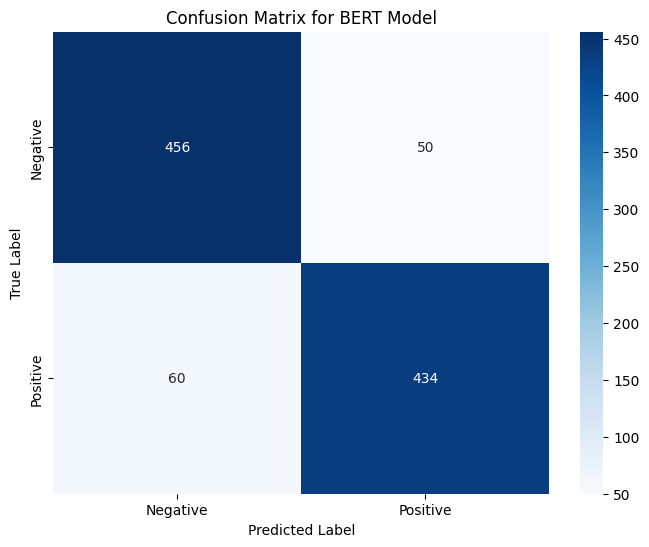


--- Phân tích lỗi ---
Tổng số lỗi: 110 / 1000

Ví dụ các trường hợp dự đoán sai (Negative -> Positive):
- Admittedly, I find Al Pacino to be a guilty pleasure. He was a fine actor until Scent of a Woman, where he apparently overdosed on himself irreparably. I hoped this film, of which I'd heard almost not...
- Routine suspense yarn about a sociopath (Dillon) who gives his sperm to a clinic of human reproduction and starts to harrass the lives of the woman (Antony) and his husband (Mancuso). Extremely predic...
- this movie delivers. the best is when the awkward teenage neighbor tries to bike away from the babysitter and in the background looks like he's never been anywhere near a bike in his life as he attemp...

Ví dụ các trường hợp dự đoán sai (Positive -> Negative):
- Thanks to this fungal film I do NOT want my Maypo, can't stomach the thought of Maltex or Wheatena, and even that granola over there doesn't look so innocent anymore! Why wasn't the song "Slop Time", ...
- I still hav

In [18]:
print("Đánh giá mô hình BERT đã fine-tune trên tập validation...")
eval_results = trainer.evaluate()
print(f"\nĐộ chính xác của BERT trên tập validation: {eval_results['eval_accuracy']:.4f}")

# Lấy dự đoán để phân tích sâu hơn
predictions = trainer.predict(tokenized_val_dataset)
y_pred_bert = np.argmax(predictions.predictions, axis=-1)
y_true = predictions.label_ids

# 1. So sánh kết quả
print("\n--- So sánh Hiệu năng ---")
print(f"Baseline (TF-IDF + LR) Accuracy: {accuracy_lr:.4f}")
print(f"BERT Fine-tuned Accuracy:        {eval_results['eval_accuracy']:.4f}")
print("-------------------------")

# 2. Ma trận nhầm lẫn (Confusion Matrix)
print("\nBáo cáo phân loại chi tiết cho BERT:")
target_names = ['Negative', 'Positive']
print(classification_report(y_true, y_pred_bert, target_names=target_names))

cm = confusion_matrix(y_true, y_pred_bert)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for BERT Model')
plt.show()

# 3. Phân tích lỗi (Error Analysis)
print("\n--- Phân tích lỗi ---")
val_texts = [item['text'] for item in val_dataset]
error_df = pd.DataFrame({
    'text': val_texts,
    'true_label': y_true,
    'predicted_label': y_pred_bert
})
misclassified = error_df[error_df['true_label'] != error_df['predicted_label']]

print(f"Tổng số lỗi: {len(misclassified)} / {len(error_df)}")

print("\nVí dụ các trường hợp dự đoán sai (Negative -> Positive):")
fp_examples = misclassified[(misclassified['true_label'] == 0) & (misclassified['predicted_label'] == 1)]
for i, row in fp_examples.head(3).iterrows():
    print(f"- {row['text'][:200]}...")

print("\nVí dụ các trường hợp dự đoán sai (Positive -> Negative):")
fn_examples = misclassified[(misclassified['true_label'] == 1) & (misclassified['predicted_label'] == 0)]
for i, row in fn_examples.head(3).iterrows():
    print(f"- {row['text'][:200]}...")

## Phần 3: Khám phá và Trực quan hóa Biểu diễn của BERT

Chúng ta sẽ trích xuất các vector embedding từ tầng cuối cùng của BERT và sử dụng t-SNE để giảm chiều và trực quan hóa chúng. Điều này giúp ta thấy được khả năng của BERT trong việc tạo ra các biểu diễn có khả năng phân tách cao.

In [19]:
print("Trích xuất embeddings từ mô hình BERT...")

# Tải mô hình tốt nhất đã được lưu
best_model_path = trainer.state.best_model_checkpoint
print(f"Đang tải mô hình tốt nhất từ: {best_model_path}")
feature_extractor = BertModel.from_pretrained(best_model_path).to(device)
feature_extractor.eval()

# Lấy một tập con nhỏ hơn để trực quan hóa
sample_dataset = tokenized_val_dataset.shuffle(seed=RANDOM_STATE).select(range(500))

def get_embeddings(batch):
    # Xóa các cột không phải là input của mô hình
    batch = {k: v for k, v in batch.items() if k in tokenizer.model_input_names}
    inputs = {k: torch.tensor(v).to(device) for k, v in batch.items()}
    with torch.no_grad():
        # Lấy hidden state của token [CLS]
        last_hidden_state = feature_extractor(**inputs).last_hidden_state
        cls_embedding = last_hidden_state[:, 0, :].cpu().numpy()
    return {"embeddings": cls_embedding}

embedded_dataset = sample_dataset.map(get_embeddings, batched=True, batch_size=16)

bert_embeddings = np.array(embedded_dataset['embeddings'])
labels = np.array(embedded_dataset['label'])

Trích xuất embeddings từ mô hình BERT...
Đang tải mô hình tốt nhất từ: ./results/checkpoint-250


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Áp dụng t-SNE để giảm chiều và trực quan hóa...


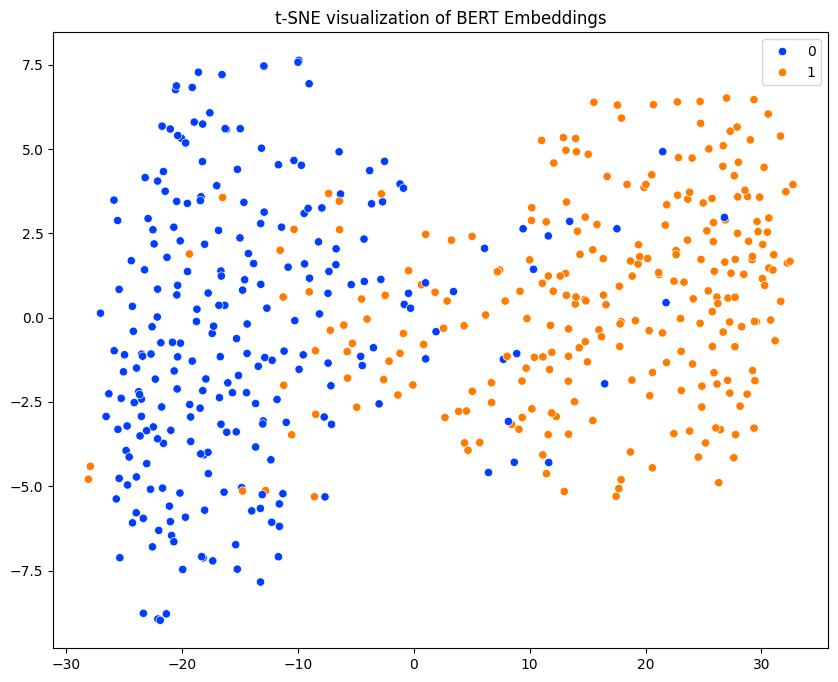

In [20]:
print("Áp dụng t-SNE để giảm chiều và trực quan hóa...")

# Giảm chiều bằng t-SNE
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, n_iter_without_progress=1000)
embeddings_2d = tsne.fit_transform(bert_embeddings)

# Trực quan hóa
plt.figure(figsize=(10, 8))
palette = sns.color_palette("bright", 2)
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=labels, legend='full', palette=palette)
plt.title('t-SNE visualization of BERT Embeddings')
plt.show()

#### So sánh với t-SNE của TF-IDF
Để thấy rõ sự khác biệt, chúng ta cũng thực hiện tương tự với vector TF-IDF.

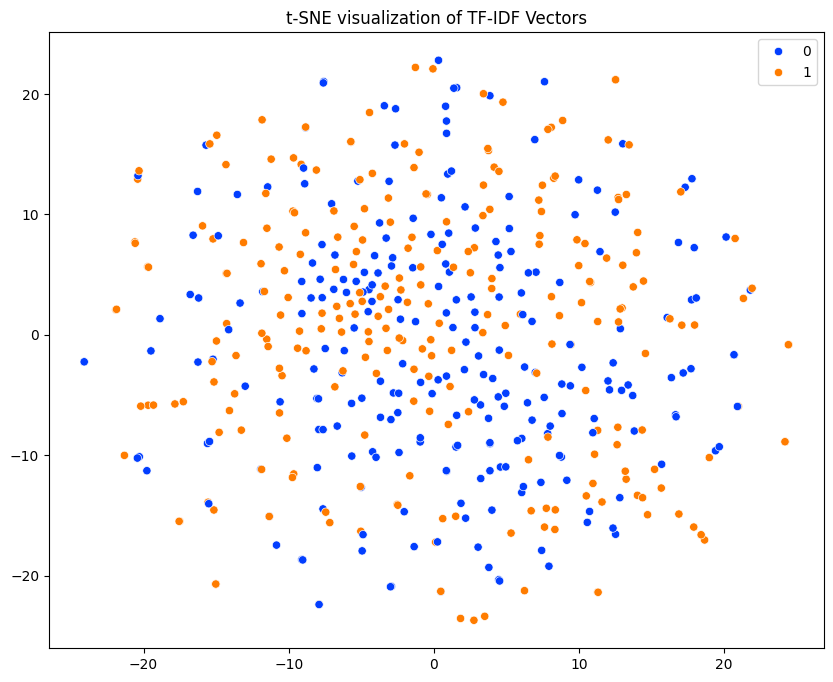

In [21]:
# Lấy vector TF-IDF cho cùng tập mẫu
sample_texts = [item['text'] for item in sample_dataset]
tfidf_embeddings = vectorizer.transform(sample_texts).toarray()

# Giảm chiều bằng t-SNE
tsne_tfidf = TSNE(n_components=2, random_state=RANDOM_STATE)
tfidf_2d = tsne_tfidf.fit_transform(tfidf_embeddings)

# Trực quan hóa
plt.figure(figsize=(10, 8))
palette = sns.color_palette("bright", 2)
sns.scatterplot(x=tfidf_2d[:, 0], y=tfidf_2d[:, 1], hue=labels, legend='full', palette=palette)
plt.title('t-SNE visualization of TF-IDF Vectors')
plt.show()

## Phần 4: Trực quan hóa Trọng số Attention

Cuối cùng, sử dụng thư viện `bertviz` để nhìn vào "bên trong" mô hình, xem nó chú ý đến những từ nào khi xử lý một câu. Điều này giúp giải thích cách mô hình đưa ra quyết định.

In [22]:
from transformers import AutoTokenizer, AutoModel
from bertviz import model_view

best_model_path = trainer.state.best_model_checkpoint
model_for_viz = AutoModel.from_pretrained(best_model_path, output_attentions=True)
tokenizer_for_viz = AutoTokenizer.from_pretrained(best_model_path)

# Chọn một câu phức tạp để phân tích
text = "The movie was not bad, actually it was quite good and I enjoyed it."

inputs = tokenizer_for_viz(text, return_tensors='pt')
outputs = model_for_viz(**inputs)
attention = outputs.attentions  # Lấy attention weights
tokens = tokenizer_for_viz.convert_ids_to_tokens(inputs['input_ids'][0])

print("Hiển thị attention (model view). Mở trong tab mới nếu cần.")
# Model view cho thấy attention trên tất cả các layer và head
model_view(attention, tokens)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Hiển thị attention (model view). Mở trong tab mới nếu cần.


<IPython.core.display.Javascript object>

In [24]:
print("Hiển thị attention (head view) cho từng layer.")
# Head view cho phép xem chi tiết từng attention head
head_view(attention, tokens, layer=1)

Hiển thị attention (head view) cho từng layer.


<IPython.core.display.Javascript object>